# Time Series Analysis: Chiller Plants

In [1]:
%env KERAS_BACKEND=tensorflow

import statsmodels.formula.api as smf
import statsmodels.api as sm
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import keras
import glob
import os

from fbprophet import Prophet
from matplotlib import pyplot as plt
%matplotlib inline

env: KERAS_BACKEND=tensorflow


C:\Anaconda2\envs\py3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


In [2]:
data_src = "./data"
all_files = glob.glob(os.path.join(data_src, "np", "*.csv"))
df = pd.concat([pd.read_csv(f) for f in all_files], ignore_index=True)

C:\Anaconda2\envs\py3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
C:\Anaconda2\envs\py3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (4,8,12,18,22,26) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
C:\Anaconda2\envs\py3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (2,3,4,6,7,9,10,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [7]:
df = df.rename(columns={"Time Stamp": "timestamp"})

In [9]:
# Null values..
df = df.replace("\\N", np.nan)

# update data types. object is taken as default
dtypes = dict([(col, np.float64) for col in df.columns])
dtypes["timestamp"] = "datetime64[ns]"
df = df.astype(dtypes)

# change thde index
df.index = df.timestamp

In [10]:
# Percentage of Non-null values in the data
(df.count() * 100)  / df["timestamp"].count()

timestamp      100.000000
loadsys        100.000000
systotpower     99.987731
effsys          99.966827
hbsys           99.638964
drybulb         25.657886
wetbulb         94.502888
rh              70.426382
chwrhdr         99.900028
np1chws         99.872535
np2chws         99.699402
cwrhdr          99.912297
cwshdr          99.927293
chwfhdr         93.047382
cwfhdr          92.945820
ch1kw           95.327659
chwp1kw         95.376509
cwp1kw          95.372192
ct1kw           99.632602
ch2kw           95.324251
chwp2kw         95.374919
cwp2kw          95.388097
ct2kw           99.625558
ch3kw           95.332203
chwp3kw         95.391051
cwp3kw          95.405138
ct3kw           99.616470
dtype: float64

C:\Anaconda2\envs\py3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


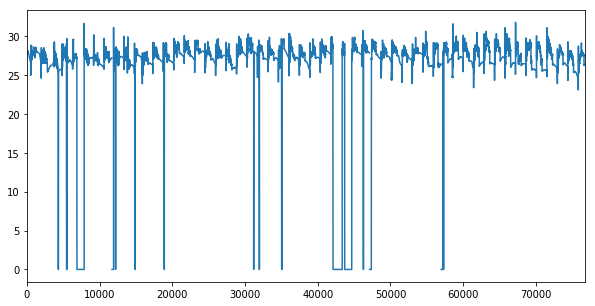

In [136]:
sample = df["2016-11": "2016-12"]
plt.figure(figsize=(10, 5))
sns.tsplot(sample.cwshdr, estimator=np.mean)

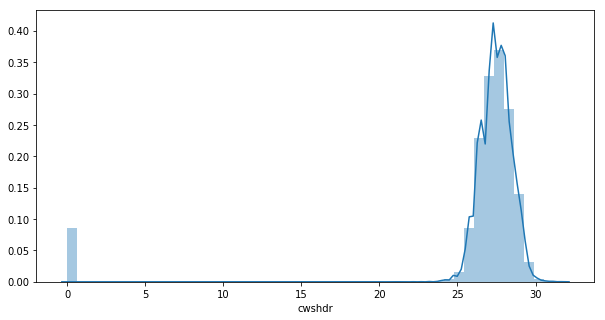

In [137]:
# Why there are 0s?? We could expect nulls.. does 0 really imply 0 or something else?
plt.figure(figsize=(10,5))
sns.distplot(sample.cwshdr.dropna())

In [138]:
print(sample.cwshdr.isnull().sum())
print((sample.cwshdr == 0).sum())
print(sample.cwshdr.max())

66
4172
31.793657


In [139]:
# How to deal with null or zero values??
# If there are few continuous null values, replacing with window average makes sense..
# but if null values appear for a very long time,.. perhaps, we should not do anything?
def replace_or_ignore(arr):
    x = arr[-1]
    if not (x == 0 or np.isnan(x)):
        return x
    arr = arr[np.nonzero(arr)]
    mean = np.nanmean(arr)
    return 0 if np.isnan(mean) else mean

ts_data = sample.cwshdr.rolling("8h").apply(replace_or_ignore)

C:\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


In [140]:
print(ts_data.isnull().sum())
print((ts_data== 0).sum())

66
1833


C:\Anaconda2\envs\py3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


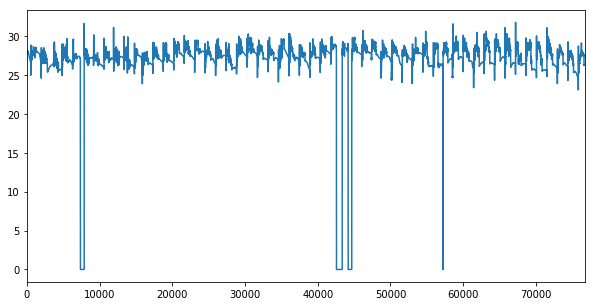

In [141]:
plt.figure(figsize=(10, 5))
sns.tsplot(ts_data, estimator=np.mean)

## Looks like there are periodic trends above... 

C:\Anaconda2\envs\py3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


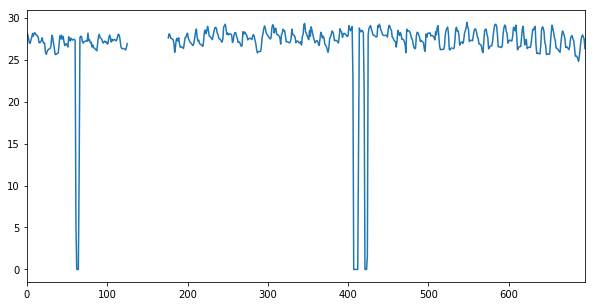

In [163]:
downsampled = ts_data.resample("2h").mean()
plt.figure(figsize=(10, 5))
sns.tsplot(downsampled, estimator=np.mean)